# Force curves versus velocity for an $F=2 \rightarrow F'=1$ system
In this notebook, we simulate cooling for an $F=2 \rightarrow F'=1$ system. In particular, we reproduce figures from [NJP 18, 123017 (2016)](https://doi.org/10.1088/1367-2630/18/12/123017).

In [1]:
using Revise

In [4]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue
;

We'll first define a few physical constants needed for this simulation. 

In [5]:
λ = 1; Γ = 2π; m = 1; k = 2π / λ;

Using `QuantumStates`, we can create both the ground states (`F1_lower`) and excited states (`F1_upper`) using the `AngularMomentumState` type, which is a state type of "bare" angular momentum states $|F,m\rangle$.

In [196]:
F_lower = 2
F_upper = 1

QN_bounds = (E = 0.0, N = F_lower)
ground_states = enumerate_states(AngularMomentumState, QN_bounds)
QN_bounds = (E = 1.0, N = F_upper)
excited_states = enumerate_states(AngularMomentumState, QN_bounds)

states = [ground_states; excited_states]
;

The transition dipole moments `d` and the magnetic moments `d_m` are calculated using `QuantumStates.get_tdms_two_bases`:

In [212]:
d_ge = get_tdms_two_bases(ground_states, excited_states, TDM)
d = zeros(length(states), length(states), 3)
d[1:length(ground_states), (length(ground_states)+1):length(states), :] .= d_ge
d[(length(ground_states)+1):length(states), 1:length(ground_states), :] .= permutedims(d_ge, (2,1,3))
;

In [213]:
d[1:5, 6:8, :] .*= sqrt(2*F_upper + 1) / sqrt(2*F_lower + 1)
d[6:8, 1:5, :] .*= sqrt(2*F_upper + 1) / sqrt(2*F_lower + 1)
;

We now define the lasers, along with the detuning $\Delta$ and saturation $s$. Note that all lasers have the polarization $\sigma^+$ in their own frame, which is rotated to the $\hat{z}$ axis using `rotate_pol`. (Technically, the rotation is performed _from_ the $\hat{z}$ axis _to_ the axis of the given laser's $k$-vector because the variable $\sigma^+$ is defined relative to the $\hat{z}$ axis.)

In [249]:
# Laser parameters
Δ = -2.5Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * (ground_states[1].E - excited_states[1].E) + Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_(rotate_pol(σ⁻, +x̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
k̂ = -x̂; ϵ2 = ϵ_(rotate_pol(σ⁺, +x̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
k̂ = +ŷ; ϵ3 = ϵ_(rotate_pol(σ⁻, +ŷ)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
k̂ = -ŷ; ϵ4 = ϵ_(rotate_pol(σ⁺, +ŷ)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁻, +ẑ)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, +ẑ)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(-rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(-rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

Before computing the force across a range of velocities, let's first check that our simulation produces reasonable results for a specific set of parameters:

In [250]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-1

p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 20p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [251]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0.4, 0.3, 0.) .* 2π
prob.p.v = (2.9, 0.0, 0.1)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-4, callback=callback)
;

  2.914265 seconds (4.00 M allocations: 282.156 MiB, 3.76% gc time, 99.09% compilation time)


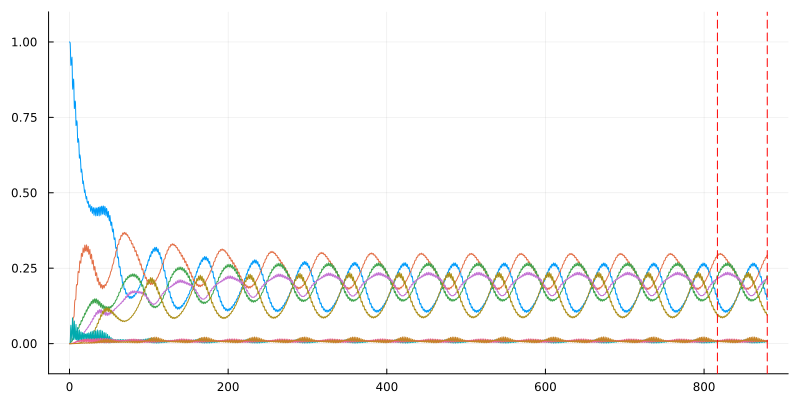

In [252]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

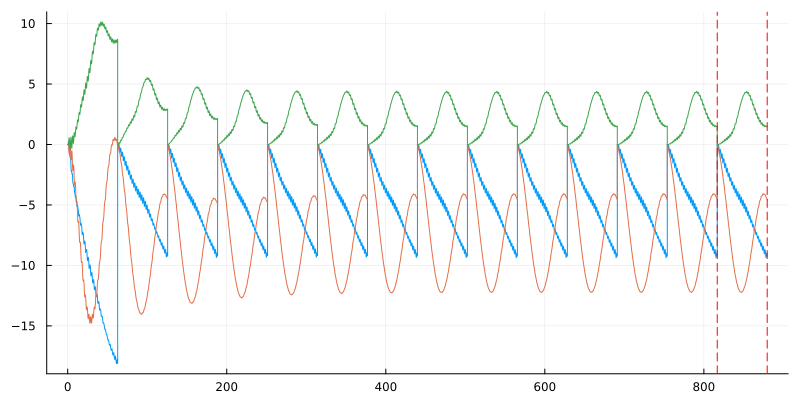

In [253]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [254]:
prob.p.force_last_period .* 1e3

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -9.237188547444102
 -4.59302882714191
  1.5235869324469615

## Laser cooling force versus velocity

In [255]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

In [256]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [257]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 500
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [258]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:38m


158.544923 seconds (8.22 M allocations: 2.552 GiB, 0.14% gc time, 19.82% compilation time)


In [259]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  3.400398 seconds (1.35 M allocations: 1.162 GiB, 5.45% gc time, 2.37% compilation time)


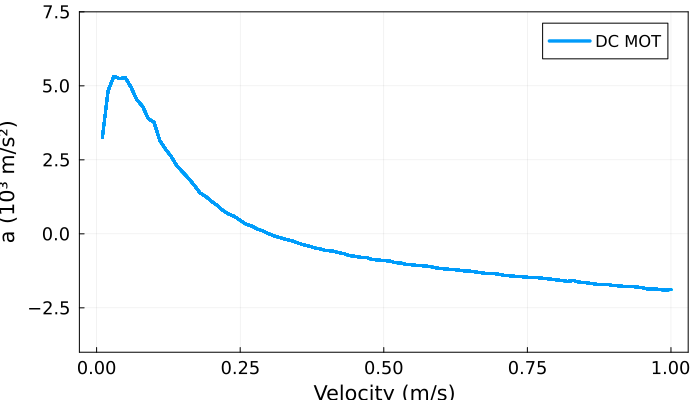

In [260]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-4,7.5),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [338]:
function prob_func!(p, scan_values, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_values.vs[i])
    p.r0 .= rand(uniform_dist, 3)
    # Round `v` to ensure that the OBEs are periodic
    p.v .= round_vel(p.v, p.freq_res)
    p.B .= (0.0, 0.0, scan_values.Bz[i])
    prob
end
function param_func(p, scan_values, i)
    return p.B[3]
end
function output_func(p, sol)
    f = p.force_last_period[3]
    # return f ⋅ p.v / norm(p.v)
    return f
end
;

In [ ]:
p = obe(ρ0, particle, states, lasers, d, d_m, true, true, λ, Γ, freq_res, nothing)
ODEProblem(ρ!, p.ρ0_vec, tspan, p, save_on=false)

n_samples = 200

Bzs = (0:0.1:2.0) ./ (2π)
vs  = 0.1 .* ones(length(Bzs))
scan_values = (Bz = repeat(Bzs, n_samples), vs = repeat(vs, n_samples))

@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress:   0%|█                                        |  ETA: 17:36:35┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Christian Hallas\.julia\packages\SciMLBase\ZGRni\src\integrator_interface.jl:502
Progress:   0%|█                                        |  ETA: 18:32:15┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Christian Hallas\.julia\packages\SciMLBase\ZGRni\src\integrator_interface.jl:502


In [ ]:
using LaTeXStrings
Bzs, averaged_forces = average_forces(scan_params, forces)
plot(Bzs .* (2π), 1e3 * averaged_forces, 
    xlabel="Magnetic field along z (ħΓ/μ)",
    ylabel="z force (10⁻³ ħkΓ)",
    legend=nothing, 
    linewidth=2)